In [1]:
from split_data import split
import numpy as np
import torch
from torchvision.datasets import ImageFolder
import torch.nn as nn
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split

from utils import *
from convert_MLModel import convert_to_mlmodel


In [2]:
if torch.backends.mps.is_available():
    device = torch.device("mps")
elif torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

print(f"Using {device}")

Using mps


In [3]:
source_path = "../Combined_data"
training_path = "../Combined_train_test/train"
testing_path = "../Combined_train_test/test"
train_test_ratio = 0.7
split(source_path, training_path, testing_path, train_test_ratio) 

Finish splitting Grape_Esca
[Training Samples:968, Testing Samples:415]   Original Samples:1383
---------------------
Finish splitting Tomato_Healthy
[Training Samples:1114, Testing Samples:477]   Original Samples:1591
---------------------
Finish splitting Grape_Healthy
[Training Samples:700, Testing Samples:300]   Original Samples:1000
---------------------
Finish splitting Tomato_Early_blight
[Training Samples:700, Testing Samples:300]   Original Samples:1000
---------------------
Finish splitting No_leaves
[Training Samples:800, Testing Samples:343]   Original Samples:1143
---------------------
Finish splitting Grape_Black_rot
[Training Samples:826, Testing Samples:354]   Original Samples:1180
---------------------
Finish splitting Apple_Healthy
[Training Samples:1151, Testing Samples:494]   Original Samples:1645
---------------------
Finish splitting Tomato_Yellow_Leaf_Curl_Virus
[Training Samples:3750, Testing Samples:1607]   Original Samples:5357
---------------------
Finish spl

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


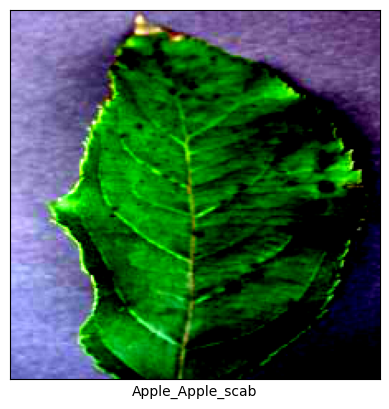

In [4]:
# -------------[transform into suitable size for transfer learning]--------------------
transformation = preprocess()

train_dataset = ImageFolder(training_path, transform = transformation)

test_dataset = ImageFolder(testing_path,transform = transformation)

classes = train_dataset.classes

#display the first image in the dataset
display_img(*train_dataset[0], classes)

In [6]:
batch_size = 128
train_val_ratio = 0.8
val_size = int(np.round(len(train_dataset) * (1-train_val_ratio)))
train_size = len(train_dataset) - val_size 

train_data, val_data = random_split(train_dataset,[train_size,val_size])
print(f"Length of Train Data : {len(train_data)}")
print(f"Length of Validation Data : {len(val_data)}")

train_dl = DataLoader(train_data, batch_size, shuffle = True, num_workers = 4, pin_memory = True)
val_dl = DataLoader(val_data, batch_size, num_workers = 4, pin_memory = True)

test_dl = DataLoader(test_dataset, batch_size, num_workers = 4, pin_memory = True)

Length of Train Data : 18066
Length of Validation Data : 4517


### EfficientB0 Model 

In [20]:
efficient_model = load_efficient_net().to(device)

num_classes = len(classes)

efficient_model.classifier = nn.Sequential(
    nn.Dropout(p=0.2, inplace=True),
    nn.Linear(in_features=1280, out_features=num_classes, bias=True)
).to(device)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(efficient_model.parameters(), lr=0.005)

# efficientNet B0 model
efficient_results = train(model=efficient_model,
                train_dataloader=train_dl,
                val_dataloader=val_dl,
                optimizer=optimizer,
                loss_fn=loss_fn,
                epochs=15,
                device=device)

torch.save(efficient_model, "../Models/combined_efficient_model.pt")

  0%|          | 0/15 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.4943 | train_acc: 0.8699 | train_f1: 0.8701 | val_loss: 0.1960 | val_acc: 0.9378 | val_f1: 0.9387 | 
--------------------------------------------------------------
Epoch: 2 | train_loss: 0.2015 | train_acc: 0.9401 | train_f1: 0.9410 | val_loss: 0.1584 | val_acc: 0.9461 | val_f1: 0.9466 | 
--------------------------------------------------------------
Epoch: 3 | train_loss: 0.1569 | train_acc: 0.9510 | train_f1: 0.9507 | val_loss: 0.1427 | val_acc: 0.9522 | val_f1: 0.9517 | 
--------------------------------------------------------------
Epoch: 4 | train_loss: 0.1417 | train_acc: 0.9538 | train_f1: 0.9539 | val_loss: 0.1240 | val_acc: 0.9599 | val_f1: 0.9602 | 
--------------------------------------------------------------
Epoch: 5 | train_loss: 0.1248 | train_acc: 0.9600 | train_f1: 0.9601 | val_loss: 0.1321 | val_acc: 0.9549 | val_f1: 0.9551 | 
--------------------------------------------------------------
Epoch: 6 | train_loss: 0.1218 | train_acc: 0.9613 | tra

In [21]:
# accuracy for efficientNet b0
if torch.backends.mps.is_available():
    efficient_model = torch.load("../Models/combined_efficient_model.pt", map_location=torch.device('mps'))
elif torch.cuda.is_available():
    efficient_model = torch.load("../Models/combined_efficient_model.pt", map_location=torch.device('cuda'))
    
efficient_report = test_run(efficient_model, test_dl, device, batch_size, classes)
print(efficient_report)

                               precision    recall  f1-score   support

             Apple_Apple_scab       0.97      0.99      0.98       300
              Apple_Black_rot       0.99      0.99      0.99       300
       Apple_Cedar_apple_rust       0.99      1.00      0.99       300
                Apple_Healthy       0.99      0.98      0.98       494
              Grape_Black_rot       0.98      0.95      0.96       354
                   Grape_Esca       0.96      0.99      0.98       415
                Grape_Healthy       0.99      0.99      0.99       300
            Grape_Leaf_blight       1.00      0.98      0.99       323
                    No_leaves       0.99      0.99      0.99       343
          Potato_Early_blight       0.98      0.97      0.97       300
               Potato_Healthy       0.99      0.99      0.99       300
           Potato_Late_blight       0.97      0.93      0.95       300
        Tomato_Bacterial_spot       0.94      0.96      0.95       638
     

### MobileV2 Model

In [22]:
mobile_model = load_mobile_net().to(device)

mobile_model.classifier = nn.Sequential(
    nn.Dropout(p=0.2, inplace=False),
    nn.Linear(in_features=1280, out_features=num_classes, bias=True)
).to(device)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(mobile_model.parameters(), lr=0.005)

# MobileNet V2 model
mobile_results = train(model=mobile_model,
                train_dataloader=train_dl,
                val_dataloader=val_dl,
                optimizer=optimizer,
                loss_fn=loss_fn,
                epochs=15,
                device=device)

torch.save(mobile_model, "../Models/combined_mobile_model.pt")

  0%|          | 0/15 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.5410 | train_acc: 0.8621 | train_f1: 0.8616 | val_loss: 0.2081 | val_acc: 0.9465 | val_f1: 0.9460 | 
--------------------------------------------------------------
Epoch: 2 | train_loss: 0.1860 | train_acc: 0.9489 | train_f1: 0.9486 | val_loss: 0.1629 | val_acc: 0.9548 | val_f1: 0.9544 | 
--------------------------------------------------------------
Epoch: 3 | train_loss: 0.1413 | train_acc: 0.9603 | train_f1: 0.9610 | val_loss: 0.1512 | val_acc: 0.9501 | val_f1: 0.9491 | 
--------------------------------------------------------------
Epoch: 4 | train_loss: 0.1152 | train_acc: 0.9668 | train_f1: 0.9666 | val_loss: 0.1297 | val_acc: 0.9593 | val_f1: 0.9590 | 
--------------------------------------------------------------
Epoch: 5 | train_loss: 0.1026 | train_acc: 0.9714 | train_f1: 0.9723 | val_loss: 0.1113 | val_acc: 0.9637 | val_f1: 0.9635 | 
--------------------------------------------------------------
Epoch: 6 | train_loss: 0.0905 | train_acc: 0.9739 | tra

In [7]:
# MobileNet V2 accuracy
if torch.backends.mps.is_available():
    mobile_model = torch.load("../Models/combined_mobile_model.pt", map_location=torch.device('mps'))
elif torch.cuda.is_available():
    mobile_model = torch.load("../Models/combined_mobile_model.pt", map_location=torch.device('cuda'))
    

mobile_report = test_run(mobile_model, test_dl, device, batch_size, classes)
print(mobile_report)

                               precision    recall  f1-score   support

             Apple_Apple_scab       0.99      0.97      0.98       300
              Apple_Black_rot       0.99      1.00      1.00       300
       Apple_Cedar_apple_rust       0.99      1.00      1.00       300
                Apple_Healthy       0.99      1.00      0.99       494
              Grape_Black_rot       0.96      0.95      0.96       354
                   Grape_Esca       0.97      0.97      0.97       415
                Grape_Healthy       1.00      0.99      1.00       300
            Grape_Leaf_blight       1.00      0.98      0.99       323
                    No_leaves       1.00      0.99      1.00       343
          Potato_Early_blight       0.96      1.00      0.98       300
               Potato_Healthy       0.97      1.00      0.99       300
           Potato_Late_blight       0.98      0.93      0.95       300
        Tomato_Bacterial_spot       0.95      0.96      0.96       638
     

### Predicting Single Image

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor([[ -9.8628, -14.5913, -11.4335, -13.2771,   0.8325,  13.0233, -10.3457,
          -7.5404,  -9.9657, -14.8891, -15.5362, -15.3635, -14.3435, -10.9504,
         -29.9704,  -7.3639,  -8.3417, -17.7936,  -7.7571, -15.3147, -15.1004,
         -15.7085]], device='mps:0')


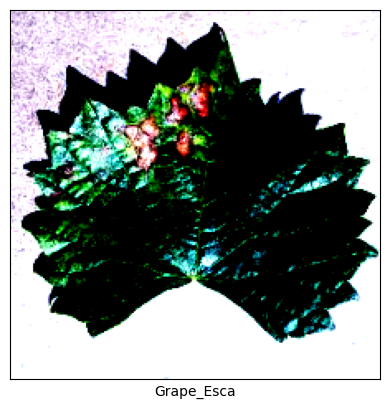

In [8]:
from PIL import Image
test_img_path = "/Users/afflatus/Documents/UoM_MSc/Diss/test_data/Grape/Esca_(Black_Measles)/image (51).JPG"

img = Image.open(test_img_path)


img1 = transformation(img)

display_img(img1, predict(mobile_model, test_img_path, device), classes)

In [9]:
display_img(img1, predict(efficient_model, test_img_path, device), classes)

NameError: name 'efficient_model' is not defined

### Convert to ML Model


In [10]:
classes

['Apple_Apple_scab',
 'Apple_Black_rot',
 'Apple_Cedar_apple_rust',
 'Apple_Healthy',
 'Grape_Black_rot',
 'Grape_Esca',
 'Grape_Healthy',
 'Grape_Leaf_blight',
 'No_leaves',
 'Potato_Early_blight',
 'Potato_Healthy',
 'Potato_Late_blight',
 'Tomato_Bacterial_spot',
 'Tomato_Early_blight',
 'Tomato_Healthy',
 'Tomato_Late_blight',
 'Tomato_Leaf_Mold',
 'Tomato_Mosaic_virus',
 'Tomato_Septoria_leaf_spot',
 'Tomato_Spider_mites',
 'Tomato_Target_Spot',
 'Tomato_Yellow_Leaf_Curl_Virus']

In [11]:
mobile_model.to('cpu')
convert_to_mlmodel(mobile_model, classes, "combined_model",test_img_path) 

Running MIL default pipeline:   0%|          | 0/56 [00:00<?, ? passes/s]/Users/afflatus/opt/miniconda3/envs/diss/lib/python3.8/site-packages/coremltools/converters/mil/mil/passes/defs/preprocess.py:262: UserWarning: Output, '824', of the source model, has been renamed to 'var_824' in the Core ML model.
  warnings.warn(msg.format(var.name, new_name))
Translating MIL ==> NeuralNetwork Ops: 100%|██████████| 495/495 [00:01<00:00, 408.50 ops/s] 


-------------Convert successfully-------------------
Model saved at../ML_Models/combined_model.mlmodel
-------------Testing converted model----------------
Grape_Esca
